In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests

sns.set()

In [2]:
url = 'http://api.scb.se/OV0104/v1/doris/sv/ssd/START/BE/BE0101/BE0101A/BefolkningR1860'

url_data = {
  "query": [
    {
      "code": "Alder",
      "selection": {
        "filter": "vs:ÅlderTotA",
        "values": []
      }
    },
    {
      "code": "Kon",
      "selection": {
        "filter": "item",
        "values": [
          "1",
          "2"
        ]
      }
    }
  ],
  "response": {
    "format": "json"
  }
}

In [3]:
r = requests.post(url, json=url_data)
r.status_code

200

In [4]:
json = r.json()

In [5]:
data = json['data']
data[0]

{'key': ['1', '1860'], 'values': ['1874399']}

In [6]:
data_list = []

for rec in data:
    data_list.append((rec['key'][0],rec['key'][1],rec['values'][0]))

In [7]:
df = pd.DataFrame(data_list)
df.columns=['gender','year','population']
df['population'] = df['population'].astype(int)

In [8]:
population = df.groupby('year').sum()
population['factor'] = population['population'] / population['population'].shift()
population.loc['2020','population'] = population.loc['2019','population'] * population.loc['2019','factor'] 
population

,population,factor
year,,
1860,3.859728e+06,NaN
1861,3.917339e+06,1.014926
1862,3.965899e+06,1.012396
1863,4.022564e+06,1.014288
1864,4.070061e+06,1.011808
...,...,...
2016,9.995153e+06,1.014632
2017,1.012024e+07,1.012515
2018,1.023018e+07,1.010864


In [9]:
url = 'http://api.scb.se/OV0104/v1/doris/sv/ssd/START/BE/BE0101/BE0101G/ManadFoddDod'
data = {
  "query": [
    {
      "code": "Kon",
      "selection": {
        "filter": "item",
        "values": [
          "1",
          "2"
        ]
      }
    },
    {
      "code": "Manad",
      "selection": {
        "filter": "item",
        "values": [
          "01",
          "02",
          "03",
          "04",
          "05",
          "06",
          "07",
          "08",
          "09",
          "10",
          "11",
          "12",
          "90"
        ]
      }
    },
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "000000NF"
        ]
      }
    }
  ],
  "response": {
    "format": "json"
  }
}

In [10]:
r = requests.post(url,json=data)
r.status_code

200

In [11]:
data_list=[]

json = r.json()

data = json['data']

for rec in data:
    data_list.append((rec['key'][0],rec['key'][1],rec['key'][2],rec['values'][0]))

In [12]:
deaths = pd.DataFrame(data_list)
deaths.columns=['gender','month','year','dead']
deaths['dead'] = deaths['dead'].astype(int)
deaths = deaths.groupby('year').sum()
deaths

,dead
year,
1851,72506
1852,80090
1853,84047
1854,70846
1855,77734
...,...
2015,90907
2016,90982
2017,91972


In [13]:
def parse_scb_prel():
    
    def monthname2number(m):
        if m == 'januari' : return 1
        if m == 'februari' : return 2
        if m == 'mars' : return 3
        if m == 'april' : return 4
        if m == 'maj' : return 5
        if m == 'juni' : return 6
        if m == 'juli' : return 7
        if m == 'augusti' : return 8
        if m == 'september' : return 9
        if m == 'oktober' : return 10
        if m == 'november' : return 11
        if m == 'december' : return 12

    df = pd.read_csv('scb-dead_per_day.csv',sep=';',usecols=[1,2,3,4,5,6,7,10,11],thousands=',')
        
    df['month'] = df['Månad'].apply(monthname2number)
    df[['Månad','month']] = df[['Månad','month']].replace(np.nan,0)
    df['month'] = df['month'].astype(int)
    
    df = df.replace(np.nan,0)
    
    df[['2015','2016','2017','2018','2019','2020','2015-2019']] = df[['2015','2016','2017','2018','2019','2020','2015-2019']].astype(int)

    
    unknown_death_day = df.iloc[-1,:7]
    
    df.drop(366,inplace=True)
    
    df = df.loc[df['2020'] != 0]
    
    #df = df.drop('Månad',axis=1)
    
    index = pd.date_range('2020-01-01',periods=len(df))
    df.index = index
    
    known_death_day = df.iloc[:,:7].sum()
    
    year_fraction = len(df) / 366
    
    unknown_death_day[['2015','2016','2017','2018','2019','2015-2019']] = unknown_death_day[
    ['2015','2016','2017','2018','2019','2015-2019']] * year_fraction
    
    dead_pct_per_day = df[['2015','2016','2017','2018','2019','2020','2015-2019']] / known_death_day
    
    all_deaths = df[['2015','2016','2017','2018','2019','2020','2015-2019']] + unknown_death_day * dead_pct_per_day
    
    all_deaths = pd.concat([all_deaths,df['Månad']],axis=1)
    
    return all_deaths
    

In [14]:
deaths_2020 = parse_scb_prel()['2020']

last_day_nr = deaths_2020.index[-1].dayofyear
last_day_nr

318

In [15]:
YTD_deaths = deaths_2020.sum()
YTD_deaths

81467.99999999999

In [16]:
full_year_deaths = 1 / (last_day_nr/365) * YTD_deaths
full_year_deaths

93508.8679245283

In [17]:
deaths.loc['2020','dead'] = full_year_deaths

In [18]:
deaths

,dead
year,
1851,72506.000000
1852,80090.000000
1853,84047.000000
1854,70846.000000
1855,77734.000000
...,...
2016,90982.000000
2017,91972.000000
2018,92185.000000


In [19]:
historical_pop = population.join(deaths)

In [20]:
historical_pop.drop('factor',axis=1,inplace=True)
historical_pop

,population,dead
year,,
1860,3.859728e+06,67502.000000
1861,3.917339e+06,71829.000000
1862,3.965899e+06,84350.000000
1863,4.022564e+06,77227.000000
1864,4.070061e+06,81937.000000
...,...,...
2016,9.995153e+06,90982.000000
2017,1.012024e+07,91972.000000
2018,1.023018e+07,92185.000000


In [21]:
historical_pop['mortality'] = historical_pop['dead'] / historical_pop['population']
historical_pop

,population,dead,mortality
year,,,
1860,3.859728e+06,67502.000000,0.017489
1861,3.917339e+06,71829.000000,0.018336
1862,3.965899e+06,84350.000000,0.021269
1863,4.022564e+06,77227.000000,0.019198
1864,4.070061e+06,81937.000000,0.020132
...,...,...,...
2016,9.995153e+06,90982.000000,0.009103
2017,1.012024e+07,91972.000000,0.009088
2018,1.023018e+07,92185.000000,0.009011


/usr/local/lib64/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


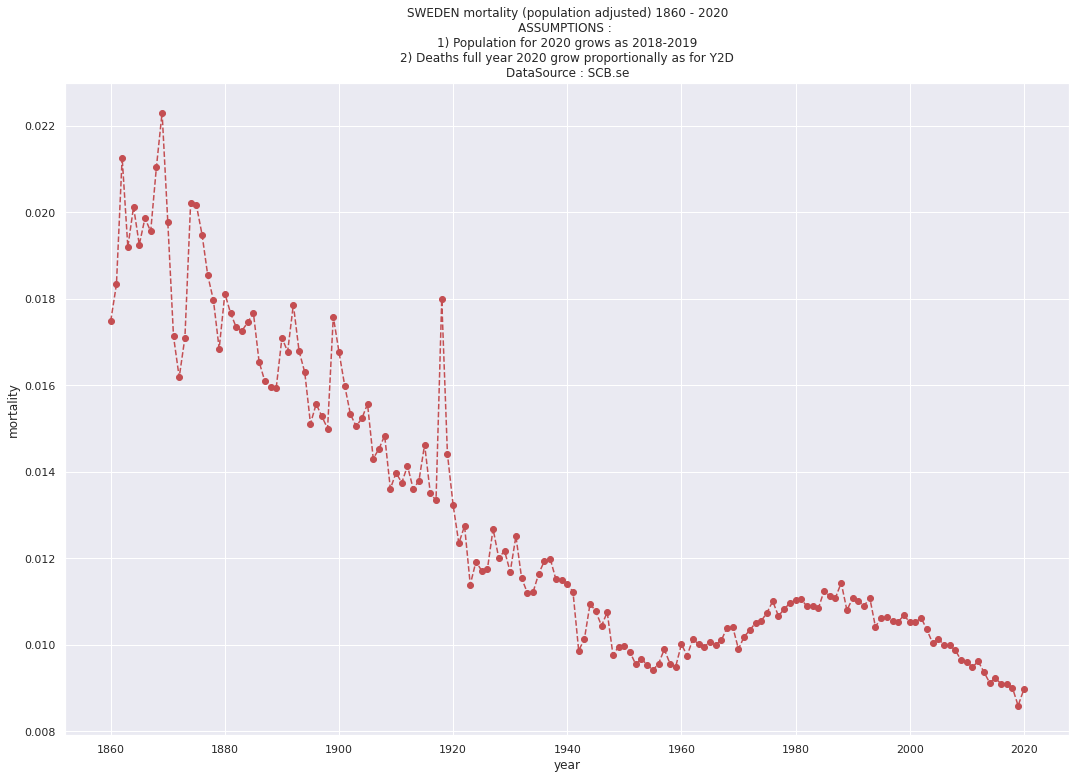

In [22]:
historical_pop['mortality'].plot(style='ro--',figsize=(18,12),
                                 title='SWEDEN mortality (population adjusted) 1860 - 2020\n'\
                                'ASSUMPTIONS : \n1) Population for 2020 grows as 2018-2019\n'\
                                '2) Deaths full year 2020 grow proportionally as for Y2D\n'\
                                'DataSource : SCB.se')

plt.ylabel('mortality')
plt.savefig('scb_historical_pop_dead.jpg',format='jpg',dpi=400)

In [23]:
historical_pop.loc['1915' : '1920']

,population,dead,mortality
year,,,
1915,5712740.0,83587.0,0.014632
1916,5757566.0,77771.0,0.013508
1917,5800847.0,77385.0,0.013340
1918,5813850.0,104591.0,0.017990
1919,5847037.0,84289.0,0.014416
1920,5904489.0,78128.0,0.013232
